# WNTR GIS Tutorial
The following tutorial illustrates the use of the `wntr.gis` module to use geospatial data in resilience analysis.  The tutorial uses a water network model from Kentucky coupled with GIS data to quantify potential water service disruptions from pipes damaged in a landslide.

## Imports
Import WNTR and additional Python packages that are needed for the tutorial
- Geopandas is used to load and manipulate geospatial data
- Shapely is used to define the region of interest
- Matplotlib is used to create subplots

In [1]:
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pylab as plt
import wntr

# Water Network Model
Water network models can be created from EPANET INP files, from GIS data in GeoJSON or Shapefile format, or from scratch using methods such as `add_junction` and `add_pipe`. The following section creates a water network model from an EPANET INP file and illustrates how models are created from GIS data.

## Create a Water Network Model from an EPANET INP file
The water distribution network model used in this tutorial was downloaded from the [UKnowledge Water Distribution Systems Research Database](https://uknowledge.uky.edu/wdsrd/). KY10 was selected for the analysis.

Citation: Hoagland, Steven, "10 KY 10" (2016). Kentucky Dataset. 12. https://uknowledge.uky.edu/wdst/12. Accessed on 4/4/2024.

In [2]:
# Create a water network model from an INP file
inp_file = '../networks/ky10.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

In [3]:
# Print a basic description of the model
wn.describe(level=1)

{'Nodes': {'Junctions': 920, 'Tanks': 13, 'Reservoirs': 2},
 'Links': {'Pipes': 1043, 'Pumps': 13, 'Valves': 5},
 'Patterns': 4,
 'Curves': {'Pump': 0, 'Efficiency': 0, 'Headloss': 0, 'Volume': 0},
 'Sources': 0,
 'Controls': 6}

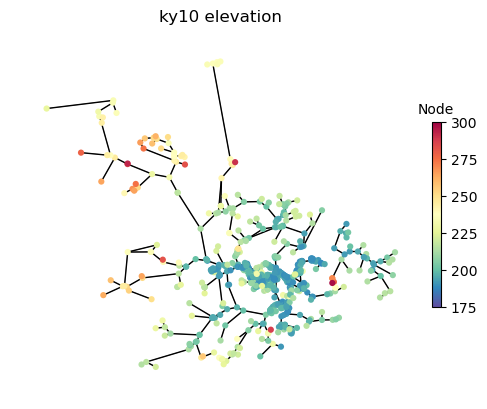

In [4]:
# Create a basic network graphic, showing junction elevation
# Note, the remaining graphics in this tutorial are created from the geospatial data directly, rather than the plot_network function
ax = wntr.graphics.plot_network(wn, node_attribute='elevation', node_range=(175, 300), title='ky10 elevation')

## Convert the Water Network Model to GIS data
The Water Network Model is converted to a collection of GeoDataFrames and set the coordinate reference system (CRS) is set to EPSG:3089.  Data for junctions, tanks, reservoirs, pipes, pumps, and valves are stored in separate GeoDataFrames.

In [5]:
# Convert the Water Network Model to GIS data and set the CRS
wn_gis = wntr.network.to_gis(wn)
wn_gis.pipes.head()

,link_type,start_node_name,end_node_name,check_valve,diameter,initial_status,length,minor_loss,roughness,geometry
P-1,Pipe,J-1,T-9,False,0.2032,Open,150.647400,0.0,150.0,"LINESTRING (5765080.500 3843715.000, 5765082.1..."
P-10,Pipe,J-19,T-3,False,0.1016,Open,508.278079,0.0,150.0,"LINESTRING (5773843.490 3813613.000, 5774062.5..."
P-100,Pipe,J-170,J-171,False,0.1524,Open,845.762088,0.0,150.0,"LINESTRING (5741554.590 3884113.000, 5741551.8..."
P-1000,Pipe,J-396,J-138,False,0.1524,Open,1015.611888,0.0,150.0,"LINESTRING (5764266.350 3841465.000, 5764332.8..."
P-1001,Pipe,J-661,J-793,False,0.0508,Open,65.303400,0.0,150.0,"LINESTRING (5778890.430 3833727.000, 5779000.7..."


In [6]:
# Set the CRS to EPSG:3089, NAD83 / Kentucky Single Zone (ftUS)
crs = 'EPSG:3089'
wn_gis.set_crs(crs)

## Save the GIS data to a GeoJSON or Shape file
The dictionary of GeoDataFrames are written to GeoJSON files or Shapefiles.  One file is created for junctions, tanks, reservoirs, pipes, pumps, and valves.

In [7]:
wn_gis.write_geojson('ky10')

## Generate a Water Network Model from GIS data
Water network models can be created from GeoJSON files or Shapefiles. A specific set of column names are required to define junctions, tanks, reservoirs, pipes, pumps, and valves.  Model attributes like patterns, curves, and options need to be added separately.

In [8]:
# Print valid GeoJSON or Shapefiles column names required to build a model
column_names = wntr.network.io.valid_gis_names()
print("Junction column names", column_names['junctions'])
print("Tank column names", column_names['tanks'])
print("Reservoir column names", column_names['reservoirs'])
print("Pipe column names", column_names['pipes'])
print("Pump column names", column_names['pumps'])
print("Valve column names", column_names['valves'])

Junction column names ['name', 'elevation', 'coordinates', 'emitter_coefficient', 'initial_quality', 'minimum_pressure', 'required_pressure', 'pressure_exponent', 'tag']
Tank column names ['name', 'elevation', 'init_level', 'min_level', 'max_level', 'diameter', 'min_volvol_curve_name', 'overflow', 'coordinates', 'initial_quality', 'mixing_fraction', 'mixing_model', 'bulk_coeff', 'tag']
Reservoir column names ['name', 'base_head', 'head_pattern_name', 'coordinates', 'initial_quality', 'tag']
Pipe column names ['name', 'start_node_name', 'end_node_name', 'length', 'diameter', 'roughness', 'minor_loss', 'initial_status', 'check_valve', 'bulk_coeff', 'wall_coeff', 'vertices', 'tag']
Pump column names ['name', 'start_node_name', 'end_node_name', 'pump_type', 'pump_curve_name', 'powerbase_speed', 'speed_pattern_name', 'initial_status', 'initial_setting', 'efficiency', 'energy_pattern', 'energy_price', 'vertices', 'tag']
Valve column names ['name', 'start_node_name', 'end_node_name', 'diamete

In [9]:
# Build a water network model from a set of GeoJSON files
geojson_files = {'junctions': 'ky10_junctions.geojson',
                 'tanks': 'ky10_tanks.geojson',
                 'reservoirs': 'ky10_reservoirs.geojson',
                 'pipes': 'ky10_pipes.geojson',
                 'pumps': 'ky10_pumps.geojson',
                 'valves': 'ky10_valves.geojson'}
wn2 = wntr.network.read_geojson(geojson_files)

In [10]:
# Compare model attributes of the original model with the model built from GeoJSON files (note the absence of patterns and controls)
print(wn.describe(level=1))
print(wn2.describe(level=1))

{'Nodes': {'Junctions': 920, 'Tanks': 13, 'Reservoirs': 2}, 'Links': {'Pipes': 1043, 'Pumps': 13, 'Valves': 5}, 'Patterns': 4, 'Curves': {'Pump': 0, 'Efficiency': 0, 'Headloss': 0, 'Volume': 0}, 'Sources': 0, 'Controls': 6}
{'Nodes': {'Junctions': 920, 'Tanks': 13, 'Reservoirs': 2}, 'Links': {'Pipes': 1043, 'Pumps': 13, 'Valves': 5}, 'Patterns': 0, 'Curves': {'Pump': 0, 'Efficiency': 0, 'Headloss': 0, 'Volume': 0}, 'Sources': 0, 'Controls': 0}


# External GIS Data
The external data used in this tutorial includes landslide footprint data and social vulnerability data.

## Create a region of interest (ROI) for the analysis
The region of interest (ROI) is defined by a bounding box around all pipes, with a 5000 ft buffer. The ROI is used to clip external data to only include the area included in the analysis.

In [11]:
# Region of interest
bounds = wn_gis.pipes.total_bounds
geom = box(*bounds)
ROI = geom.buffer(5000) # feet

## Load landslide GIS data
The landslide data used in this tutorial was downloaded from the [UKnowledge Kentucky Geological Survey Research Data](https://uknowledge.uky.edu/kgs_data/).  The Kentucky Geological Survey Landslide Inventory from March 2023 was selected for the analysis.  The data contains landslide areas derived from aerial photography. 

Citation: Crawford, M.M., 2023. Kentucky Geological Survey landslide inventory [2023-03]: Kentucky Geological Survey Research Data, https://uknowledge.uky.edu/kgs_data/7/, Accessed on 4/4/2024.

In [12]:
# To reduce the file size checked into the WNTR repository, the following code was run on the raw data file

#landslide_file = '../data/KGS_Landslide_Inventory_exp.gdb'
#landslide_data = gpd.read_file(landslide_file, driver="FileGDB", layer='Areas_derived_from_aerial_photography')
#print(landslide_data.crs)
#landslide_data = landslide_data.clip(ROI)
#landslide_data.to_file("../data/ky10_landslide_data.geojson", index=True, driver='GeoJSON')

In [13]:
# Load the landslide data from file and print the CRS (which is already in EPSG:3089)
landslide_file = '../data/ky10_landslide_data.geojson'
landslide_data = gpd.read_file(landslide_file) 
landslide_data.set_index('index', inplace=True)
landslide_data.index.name = None
print(landslide_data.crs)

landslide_data.head()

EPSG:3089


,Type,QUADRANGLE,Confidence_Ranking,Shape_Length,Shape_Area,geometry
12158,Landslide,LANCER,3,600.093659,25776.421953,"POLYGON ((5795711.138 3796524.413, 5795749.332..."
12154,Landslide,LANCER,3,525.280081,18705.404676,"POLYGON ((5793900.026 3796635.524, 5793945.165..."
7509,Landslide,Prestonsburg,3,331.655229,7830.582786,"POLYGON ((5769026.666 3797014.993, 5769050.971..."
7511,Landslide,Prestonsburg,3,518.984567,19344.352333,"POLYGON ((5776317.985 3797039.298, 5776324.930..."
7507,Landslide,Prestonsburg,3,339.472695,8168.150433,"POLYGON ((5767849.582 3797074.020, 5767866.943..."


In [14]:
# Each landslide is extended to include the surrounding 1000 ft, to create a region that might be impacted by an individual landslide.  
# Other datasets or methods could be used to define landslide susceptibility or vulnerability.
landslide_regions = landslide_data.copy()
landslide_regions['geometry'] = landslide_data.buffer(1000)

Text(0.5, 1.0, 'Landslide and pipe data')

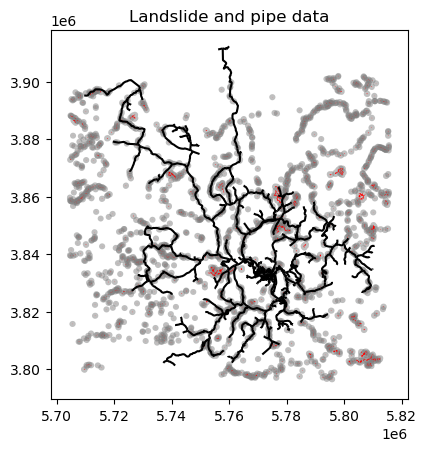

In [15]:
# Plot the landslide data and landslide regions along with pipes
ax = landslide_regions.plot(color='gray', alpha=0.5)
ax = landslide_data.plot(color='red', label='Landslide data', ax=ax)
ax = wn_gis.pipes.plot(color='black', ax=ax)
ax.set_title('Landslide and pipe data')

## Load Social Vulnerability Index (SVI) GIS data
The social vulnerability data used in this tutorial was downloaded from the [Centers for Disease Control and Prevention/Agency for Toxic Substances and Disease Registry](https://www.atsdr.cdc.gov/placeandhealth/svi/index.html). The data contains census and social vulnerability metrics for each census tract. 

The quantity of interest used in this analysis is "RPL_THEMES" which ranks vulnerability across socioeconomic status, household characteristics, racial and ethnic minority status, and housing type and transportation.  The value ranges between 0 and 1, where higher values are associated with higher vulnerability.

Citation: Centers for Disease Control and Prevention/Agency for Toxic Substances and Disease Registry/Geospatial Research, Analysis, and Services Program. CDC/ATSDR Social Vulnerability Index 2020 Database Kentucky. https://www.atsdr.cdc.gov/placeandhealth/svi/data_documentation_download.html. Accessed on 4/4/2024.

In [16]:
# To reduce the file size checked into the WNTR repository, the following code was run on the raw data file

#svi_file = '../data/SVI2020_KENTUCKY_tract.gdb'
#svi_data = gpd.read_file(svi_file, driver="FileGDB", layer='SVI2020_KENTUCKY_tract')
#print(svi_data.crs)
#svi_data.to_crs(crs, inplace=True)
#svi_data = svi_data.clip(ROI)
#svi_data.to_file("../data/ky10_svi_data.geojson", index=True, driver='GeoJSON')

In [17]:
# Load the SVI data from file and print the CRS (which is already in EPSG:3089)
svi_file = '../data/ky10_svi_data.geojson'
svi_data = gpd.read_file(svi_file)
print(svi_data.crs)
svi_data.set_index('index', inplace=True)
svi_data.index.name = None

svi_data.head()

EPSG:3089


,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE,Shape_Length,Shape_Area,geometry
985,21,Kentucky,KY,21153,Magoffin,21153970400,"Census Tract 9704, Magoffin County, Kentucky",86.743212,1800,350,...,1.9,0.0,1.9,2.3,4.6,0.0,1.9,0.890448,0.022963,"POLYGON ((5728982.375 3796262.000, 5729188.785..."
984,21,Kentucky,KY,21153,Magoffin,21153970300,"Census Tract 9703, Magoffin County, Kentucky",52.577750,3003,557,...,1.2,0.0,1.2,0.0,1.2,0.0,1.2,0.663193,0.013949,"POLYGON ((5704604.870 3803859.255, 5704998.491..."
386,21,Kentucky,KY,21071,Floyd,21071920200,"Census Tract 9202, Floyd County, Kentucky",51.065440,1545,247,...,2.2,0.0,2.2,0.1,0.2,0.0,2.2,0.720409,0.013818,"POLYGON ((5791479.459 3801489.293, 5791780.699..."
398,21,Kentucky,KY,21071,Floyd,21071921002,"Census Tract 9210.02, Floyd County, Kentucky",33.362472,3746,688,...,0.9,0.0,0.9,2.2,2.4,0.0,0.9,0.568973,0.008858,"MULTIPOLYGON (((5733681.449 3796634.816, 57344..."
385,21,Kentucky,KY,21071,Floyd,21071920100,"Census Tract 9201, Floyd County, Kentucky",12.503479,2889,382,...,1.2,0.0,1.2,0.9,1.7,0.0,1.2,0.386356,0.003420,"POLYGON ((5782256.522 3796262.000, 5782551.583..."


Text(0.5, 1.0, 'SVI and pipe data')

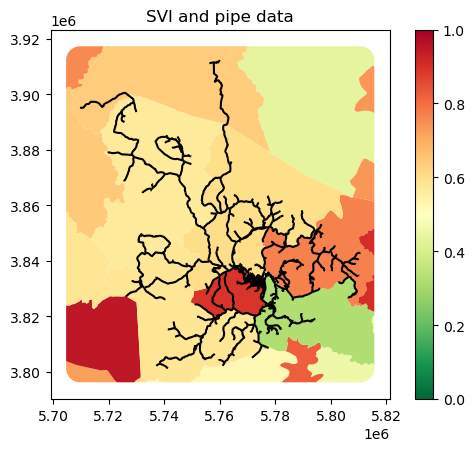

In [18]:
# Plot SVI data and pipes (higher values of SVI are associated with higher vulnerability)
ax = svi_data.plot(column='RPL_THEMES', label='SVI data', cmap='RdYlGn_r', vmin=0, vmax=1, legend=True)
ax = wn_gis.pipes.plot(color='black', ax=ax)
ax.set_title('SVI and pipe data')

# Intersect Water Network Model with GIS data
In this section, landslide and SVI data are interested with the water network model.

## Intersect pipes with landslide regions
Pipes are intersected with landslide regions to determine the landslides that could impact each pipe. This information could be used to compute the likelihood that a pipe will be impacted by landslides.

In [19]:
# Determine landslide regions that intersect each pipe and print in order of descending number of intersections.
pipe_intersect = wntr.gis.intersect(wn_gis.pipes, landslide_regions)

pipe_intersect.sort_values('n', ascending=False).head()

,intersections,n
P-449,"[5086, 5087, 5088, 5125, 5126, 5128, 5129, 513...",25
P-517,"[4553, 4554, 4555, 4556, 4557, 4558, 4559, 456...",23
P-722,"[6831, 6832, 6833, 6834, 6835, 6836, 6840, 684...",23
P-837,"[4571, 4575, 4631, 4632, 4633, 4634, 4635, 463...",23
P-442,"[6836, 6837, 6838, 6839, 6840, 6856, 6857, 685...",20


In [20]:
# Add the intersection data to the water network pipe data
wn_gis.pipes[['intersections', 'n']] = pipe_intersect
wn_gis.pipes.sort_values('n', ascending=False).head()

,link_type,start_node_name,end_node_name,check_valve,diameter,initial_status,length,minor_loss,roughness,geometry,intersections,n
P-449,Pipe,J-276,J-616,False,0.1016,Open,6482.077968,0.0,150.0,"LINESTRING (5760308.720 3869886.000, 5760219.9...","[5086, 5087, 5088, 5125, 5126, 5128, 5129, 513...",25
P-517,Pipe,J-581,J-677,False,0.1524,Open,7388.440087,0.0,100.0,"LINESTRING (5728134.870 3878198.000, 5728149.0...","[4553, 4554, 4555, 4556, 4557, 4558, 4559, 456...",23
P-722,Pipe,J-612,J-551,False,0.1016,Open,2962.692576,0.0,100.0,"LINESTRING (5768267.590 3848120.000, 5768281.8...","[6831, 6832, 6833, 6834, 6835, 6836, 6840, 684...",23
P-837,Pipe,J-236,J-860,False,0.1016,Open,7194.294984,0.0,100.0,"LINESTRING (5728952.110 3898156.000, 5725889.4...","[4571, 4575, 4631, 4632, 4633, 4634, 4635, 463...",23
P-442,Pipe,J-454,J-607,False,0.0762,Open,2015.419896,0.0,150.0,"LINESTRING (5778153.330 3852424.000, 5777683.2...","[6836, 6837, 6838, 6839, 6840, 6856, 6857, 685...",20


## Intersect landslide regions with pipes
Landslide regions are intersected with pipes to determine the pipes that could be impacted by each landslide.  This information is used to build landslide scenarios.

In [21]:
# Determine pipes that intersect each landslide region, remove landslides that intersect no pipes, and print in order of descending number of intersections.
landslide_intersect = wntr.gis.intersect(landslide_regions, wn_gis.pipes)
landslide_intersect = landslide_intersect[landslide_intersect['n'] > 0]

landslide_intersect.sort_values('n', ascending=False).head()

,intersections,n
6997,"[P-1024, P-130, P-142, P-15, P-199, P-201, P-2...",43
6980,"[P-1009, P-1012, P-141, P-155, P-205, P-213, P...",42
6995,"[P-1009, P-1024, P-15, P-309, P-347, P-370, P-...",39
6998,"[P-1024, P-130, P-15, P-201, P-233, P-327, P-3...",35
6996,"[P-1024, P-15, P-283, P-336, P-370, P-418, P-4...",35


In [22]:
# Add the intersection data to the landslide regions data
landslide_regions[['intersections', 'n']] = landslide_intersect

landslide_regions.sort_values('n', ascending=False).head()

,Type,QUADRANGLE,Confidence_Ranking,Shape_Length,Shape_Area,geometry,intersections,n
6997,Landslide,Paintsville,3,901.200109,33287.494172,"POLYGON ((5771671.869 3833401.507, 5771665.917...","[P-1024, P-130, P-142, P-15, P-199, P-201, P-2...",43.0
6980,Landslide,Paintsville,3,465.961975,15884.228569,"POLYGON ((5769629.396 3834945.820, 5769625.350...","[P-1009, P-1012, P-141, P-155, P-205, P-213, P...",42.0
6995,Landslide,Paintsville,3,1420.979306,74851.718765,"POLYGON ((5771436.047 3834066.211, 5771430.867...","[P-1009, P-1024, P-15, P-309, P-347, P-370, P-...",39.0
6998,Landslide,Paintsville,3,392.973421,11176.225254,"POLYGON ((5771891.174 3834087.953, 5771903.812...","[P-1024, P-130, P-15, P-201, P-233, P-327, P-3...",35.0
6996,Landslide,Paintsville,3,565.256386,23395.306484,"POLYGON ((5771440.224 3834157.073, 5771439.890...","[P-1024, P-15, P-283, P-336, P-370, P-418, P-4...",35.0


Text(0.5, 1.0, 'Number of pipes that intersect each landslide region')

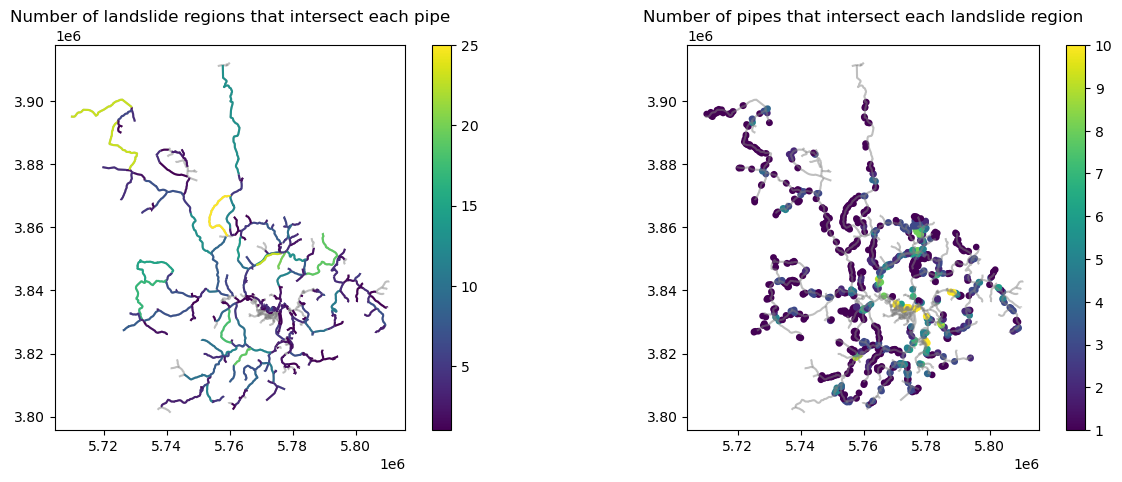

In [23]:
# Plot intersection results
fig, axes = plt.subplots(1,2, figsize=(15,5))

wn_gis.pipes.plot(color='gray', alpha=0.5, ax=axes[0])
wn_gis.pipes[wn_gis.pipes['n'] > 0].plot(column='n', legend=True, ax=axes[0])
axes[0].set_title('Number of landslide regions that intersect each pipe')

wn_gis.pipes.plot(color='gray', alpha=0.5, ax=axes[1])
landslide_regions.plot(column='n', vmax=10, legend=True, ax=axes[1])
axes[1].set_title('Number of pipes that intersect each landslide region')

## Intersect junctions with SVI data
Junctions are intersected with SVI to determine the social vulnerability of the population at each junction.  This information is used to determine the social vulnerability of individuals that experience water service disruptions.

In [24]:
# Determine the SVI of each junction using "RPL_THEMES", which ranks vulnerability across socioeconomic status, household characteristics, 
# racial and ethnic minority status, and housing type and transportation. The value ranges between 0 and 1, where higher values are associated with higher vulnerability.
junction_svi = wntr.gis.intersect(wn_gis.junctions, svi_data, 'RPL_THEMES')
junction_svi.head()

,intersections,values,n,sum,min,max,mean
J-1,[791],[0.6031],1,0.6031,0.6031,0.6031,0.6031
J-10,[787],[0.6015],1,0.6015,0.6015,0.6015,0.6015
J-100,[791],[0.6031],1,0.6031,0.6031,0.6031,0.6031
J-101,[791],[0.6031],1,0.6031,0.6031,0.6031,0.6031
J-102,[790],[0.8942],1,0.8942,0.8942,0.8942,0.8942


In [25]:
# Select the mean value to use in the analysis
wn_gis.junctions['RPL_THEMES'] = junction_svi['mean']

Text(0.5, 1.0, 'SVI value at each junction')

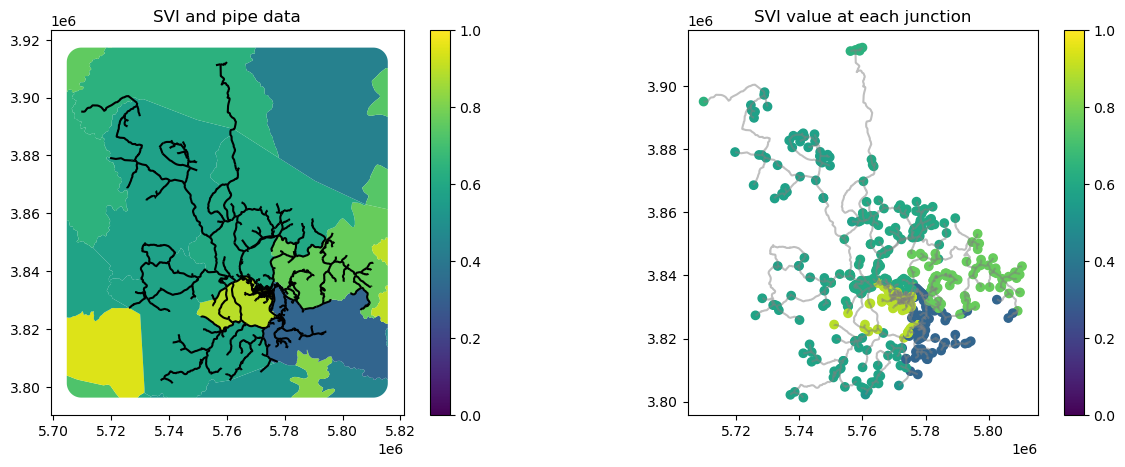

In [26]:
# Plot SVI for each census track and SVI assigned to each junction
fig, axes = plt.subplots(1,2, figsize=(15,5))

svi_data.plot(column='RPL_THEMES', label='SVI data', vmin=0, vmax=1, legend=True, ax=axes[0])
wn_gis.pipes.plot(color='black', ax=axes[0])
axes[0].set_title('SVI and pipe data')

wn_gis.pipes.plot(color='gray', alpha=0.5, ax=axes[1])
wn_gis.junctions.plot(column='RPL_THEMES', vmin=0, vmax=1, legend=True, ax=axes[1])
axes[1].set_title('SVI value at each junction')

# Hydraulic Simulations
The following section runs hydraulic simulations for the baseline (no landslide) and landslide scenarios. A subset of landslide scenarios is run to simply the tutorial. For each simulation, the water service availability (WSA) at each junction is computed.  WSA is defined as the ratio of delivered demand to the expected demand. A value below 1 indicates that expected demand is not met.

In [27]:
# Create a function to setup the model for hydraulic simulation
def model_setup(inp_file):
    wn = wntr.network.WaterNetworkModel(inp_file)
    wn.options.hydraulic.demand_model = 'PDD'
    wn.options.hydraulic.required_pressure = 20 # m
    wn.options.hydraulic.minimum_pressure  = 0 # m
    wn.options.time.duration = 48*3600 # 48 hour simulation
    return wn

## Run baseline simulation

In [28]:
# Run a baseline simulation, with no landslides or damage.  Compute water service availability (WSA ) for each junction.
wn = model_setup(inp_file)
sim = wntr.sim.EpanetSimulator(wn)
baseline_results = sim.run_sim()

expected_demand = wntr.metrics.expected_demand(wn)
demand = baseline_results.node['demand'].loc[:,wn.junction_name_list]
wsa = wntr.metrics.water_service_availability(expected_demand.sum(axis=0), demand.sum(axis=0))

wsa.head()

name
J-1      0.994994
J-10     0.979076
J-100    1.000094
J-101    0.976837
J-102    1.003030
dtype: float64

In [29]:
# Add WSA from the base simulation to the junction GIS data
wn_gis.junctions['wsa_base'] = wsa

Text(0.5, 1.0, 'Baseline WSA')

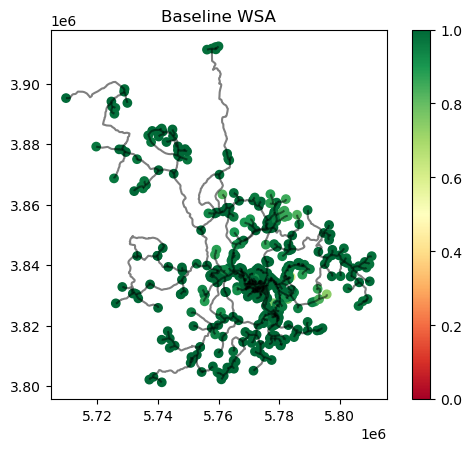

In [30]:
# Plot WSA from the base simulation
ax = wn_gis.pipes.plot(color='black', alpha=0.5)
ax = wn_gis.junctions.plot(column='wsa_base', cmap='RdYlGn', vmin=0, vmax=1, legend=True, ax=ax)
ax.set_title('Baseline WSA')

## Run landslide scenarios
Landslide scenarios are down selected by identifying the set of landslides that impact a unique set of pipes.  Scenarios are further down selected to 6 scenarios to simplify the tutorial.

In [31]:
# Down select landslide regions that impact a unique set of pipes
duplicated_intersections = landslide_regions['intersections'].astype(str).duplicated()
landslide_scenarios = landslide_regions.loc[~duplicated_intersections, :]
landslide_scenarios = landslide_scenarios.sort_values('n', ascending=False)

landslide_scenarios.head()

,Type,QUADRANGLE,Confidence_Ranking,Shape_Length,Shape_Area,geometry,intersections,n
6997,Landslide,Paintsville,3,901.200109,33287.494172,"POLYGON ((5771671.869 3833401.507, 5771665.917...","[P-1024, P-130, P-142, P-15, P-199, P-201, P-2...",43.0
6980,Landslide,Paintsville,3,465.961975,15884.228569,"POLYGON ((5769629.396 3834945.820, 5769625.350...","[P-1009, P-1012, P-141, P-155, P-205, P-213, P...",42.0
6995,Landslide,Paintsville,3,1420.979306,74851.718765,"POLYGON ((5771436.047 3834066.211, 5771430.867...","[P-1009, P-1024, P-15, P-309, P-347, P-370, P-...",39.0
6998,Landslide,Paintsville,3,392.973421,11176.225254,"POLYGON ((5771891.174 3834087.953, 5771903.812...","[P-1024, P-130, P-15, P-201, P-233, P-327, P-3...",35.0
6996,Landslide,Paintsville,3,565.256386,23395.306484,"POLYGON ((5771440.224 3834157.073, 5771439.890...","[P-1024, P-15, P-283, P-336, P-370, P-418, P-4...",35.0


In [32]:
# Further down select the landslide scenarios to a small set for demonstration purposes. Comment out the following line to run a full analysis.
landslide_scenarios = landslide_scenarios.loc[[6980, 7003, 7202, 7028,6966, 7058],:]

landslide_scenarios

,Type,QUADRANGLE,Confidence_Ranking,Shape_Length,Shape_Area,geometry,intersections,n
6980,Landslide,Paintsville,3,465.961975,15884.228569,"POLYGON ((5769629.396 3834945.820, 5769625.350...","[P-1009, P-1012, P-141, P-155, P-205, P-213, P...",42.0
7003,Landslide,Paintsville,3,330.770413,7065.011733,"POLYGON ((5775407.596 3833657.199, 5775367.408...","[P-140, P-146, P-148, P-159, P-371, P-384, P-4...",19.0
7202,Landslide,Paintsville,3,591.301241,23166.224842,"POLYGON ((5778800.284 3831520.910, 5778777.341...","[P-1032, P-161, P-227, P-307, P-476, P-479, P-...",13.0
7028,Landslide,Paintsville,3,457.786111,15618.987773,"POLYGON ((5783266.609 3829527.325, 5783271.325...","[P-135, P-182, P-183, P-420, P-850, P-884, P-9...",9.0
6966,Landslide,Paintsville,3,562.617615,22816.595980,"POLYGON ((5765524.598 3837687.738, 5765477.659...","[P-640, P-81, P-839, P-880, P-942, P-946, P-95...",8.0
7058,Landslide,Paintsville,3,631.296149,28012.891694,"POLYGON ((5775378.255 3824900.407, 5775416.447...","[P-329, P-417, P-435, P-519, P-709, P-783, P-89]",7.0


Text(0.5, 1.0, 'Landslide scenarios')

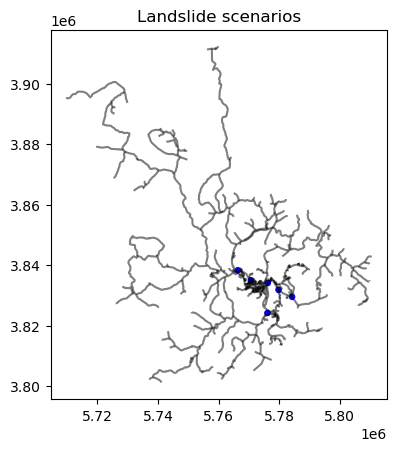

In [33]:
# Plot the location of landslide regions used in the analysis
ax = landslide_scenarios.plot(color='blue')
wn_gis.pipes.plot(color='black', alpha=0.5, ax=ax)
ax.set_title('Landslide scenarios')

In [34]:
# Run hydraulic simulations and extract water service availability for each landslide scenario.  
# Print the landslide number, the number of pipes that intersect the landslide, and the average WSA
results = {}
for i, scenario in landslide_scenarios.iterrows():
    wn = model_setup(inp_file)
    for pipe_i in scenario['intersections']:
        pipe_object =wn.get_link(pipe_i)
        pipe_object.initial_status = 'CLOSED'
    sim = wntr.sim.EpanetSimulator(wn)
    results[i] = sim.run_sim()
    
    # Compute WSA
    demand = results[i].node['demand'].loc[:,wn.junction_name_list]
    wsa = wntr.metrics.water_service_availability(expected_demand.sum(axis=0), demand.sum(axis=0))
    
    # Store WSA in the junctions geodataframe
    column_name = 'wsa_'+str(i)
    wn_gis.junctions[column_name] = wsa
    print(i, len(scenario['intersections']), wsa.mean())

6980 42 0.9447187097404451
7003 19 0.8218488117311916
7202 13 0.9277961813499142
7028 9 0.9491684683812794
6966 8 0.9210546473052833
7058 7 0.9401817890559534


# Analysis Results
The following section plots analysis results, including water service availability for the landslide scenarios and SVI of impacted junctions.

## Water Service Availability
Each scenario includes WSA for each junction.  Note that WSA can be > 1 and < 0 due to numerical differences in expected and actual demand.

<Axes: >

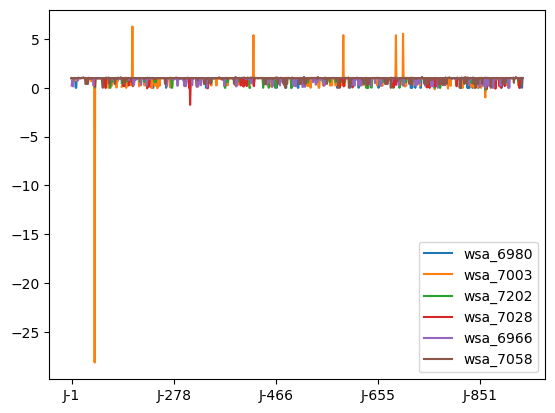

In [35]:
# Extract and plot WSA for 6 scenarios. 
column_names = ['wsa_'+str(i) for i in landslide_scenarios.iloc[0:6,:].index]
wsa_results = wn_gis.junctions[column_names]

wsa_results.plot()

C:\Users\kaklise\AppData\Local\Temp\ipykernel_51860\3792576750.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wsa_results[wsa_results < 0] = 0
C:\Users\kaklise\AppData\Local\Temp\ipykernel_51860\3792576750.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wsa_results[wsa_results < 0] = 0
C:\Users\kaklise\AppData\Local\Temp\ipykernel_51860\3792576750.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

<Axes: >

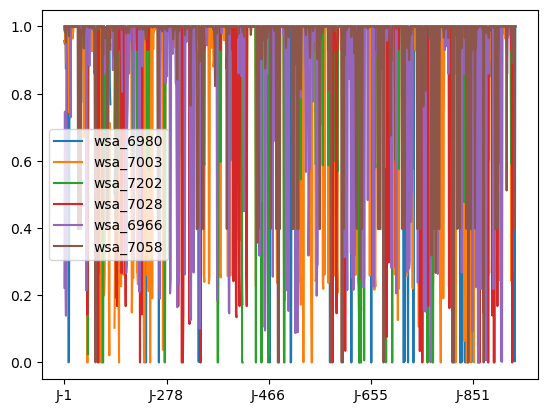

In [36]:
# Clean up and plot WSA
wsa_results[wsa_results < 0] = 0
wsa_results[wsa_results > 1] = 1

wsa_results.plot()

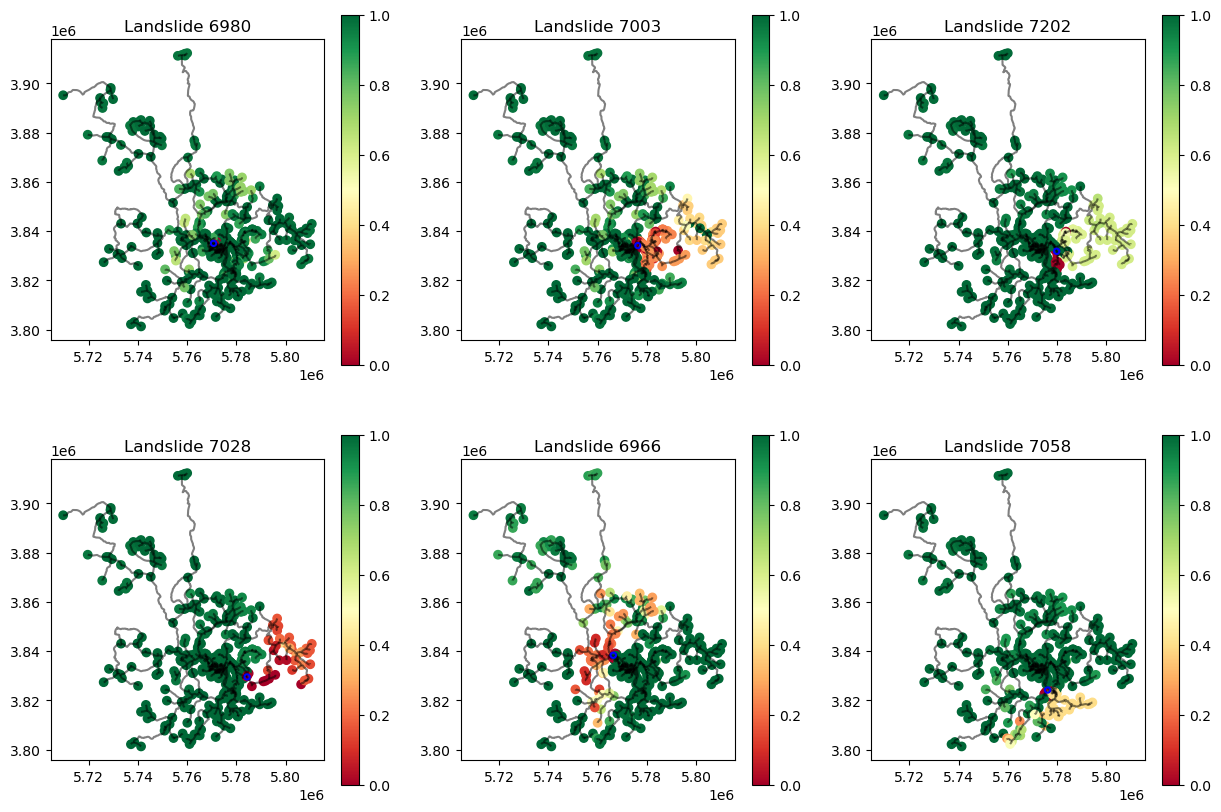

In [37]:
# Plot WSA for each scenario
fig, axes = plt.subplots(2,3, figsize=(15,10))
axes = axes.flatten()
axes_counter = 0

for i, scenario in landslide_scenarios.iterrows():
    wsa_column_name = 'wsa_'+str(i)
    ax = axes[axes_counter]
    ax = wn_gis.pipes.plot(color='black', alpha=0.5, ax=ax)
    wn_gis.junctions.plot(column=wsa_column_name, cmap='RdYlGn', vmin=0, vmax=1, legend=True, ax=ax)
    ax = landslide_scenarios.loc[[i],:].boundary.plot(color='blue', ax=ax)
    ax.set_title('Landslide ' + str(i))
    axes_counter = axes_counter + 1

## SVI of impacted junctions
In this analysis, impacted junctions are defined as junctions where WSA falls below 0.5 (50% of the water expected was received) at any time during the simulation. Other criteria could also be used to defined impact.

In [38]:
# Identify and print junctions that have WSA < 0.5
impacted = (wsa_results < 0.5).any(axis=1)
impacted_junctions = impacted[impacted == True].index

impacted_junctions

Index(['J-1', 'J-100', 'J-101', 'J-106', 'J-107', 'J-123', 'J-124', 'J-127',
       'J-128', 'J-138',
       ...
       'J-901', 'J-905', 'J-907', 'J-908', 'J-909', 'J-928', 'J-931', 'J-94',
       'J-97', 'J-98'],
      dtype='object', length=348)

Text(0.5, 1.0, 'SVI of impacted junctions')

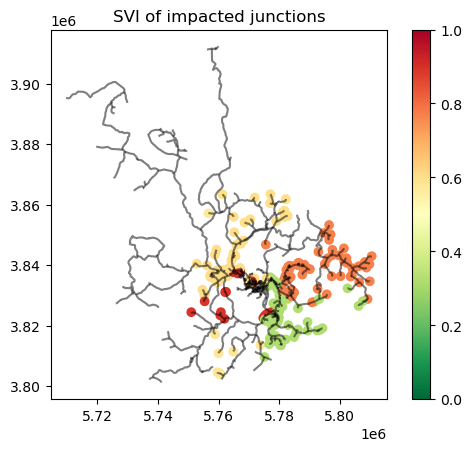

In [39]:
# Plot the SVI of impacted junctions
ax = wn_gis.pipes.plot(color='black', alpha=0.5)
wn_gis.junctions.loc[impacted_junctions,:].plot(column='RPL_THEMES', cmap='RdYlGn_r',vmin=0, vmax=1, legend=True, ax=ax)
ax.set_title('SVI of impacted junctions')

## Save analysis results to GIS files
Results that are added to the `wn_gis` object can be saved to GIS formatted files.  Note that lists (such as the information stored in 'intersections' is not JSON serializable and must first be removed.  The resulting GIS files contain WSA per scenario and can be loaded into GIS platforms for further analysis.

In [40]:
del wn_gis.pipes['intersections']
wn_gis.write_geojson('ky10_analysis_results')